In [16]:
import pandas as pd

test_sample = pd.read_csv('sample_data/test_sample.csv')
train_sample = pd.read_csv('sample_data/train_sample.csv')
label_count = pd.read_csv('sample_data/labelCount.csv', names=['ID', 'Metric', 'Value'])

In [ ]:
print(test_sample.head())
print(train_sample.head())
print(label_count.head())

In [6]:
import pandas as pd

print(test_sample.isnull().sum())
print(train_sample.isnull().sum())
print(label_count.isnull().sum())

sentence         0
numerals-tags    0
company          0
docEndDate       0
docType          0
fileName         0
year             0
ner_tags         0
tokens           0
dtype: int64
sentence         0
numerals-tags    0
company          0
docEndDate       0
docType          0
fileName         0
year             0
ner_tags         0
tokens           0
dtype: int64
0                                             0
us-gaap:LossContingencyDamagesAwardedValue    0
128                                           0
dtype: int64


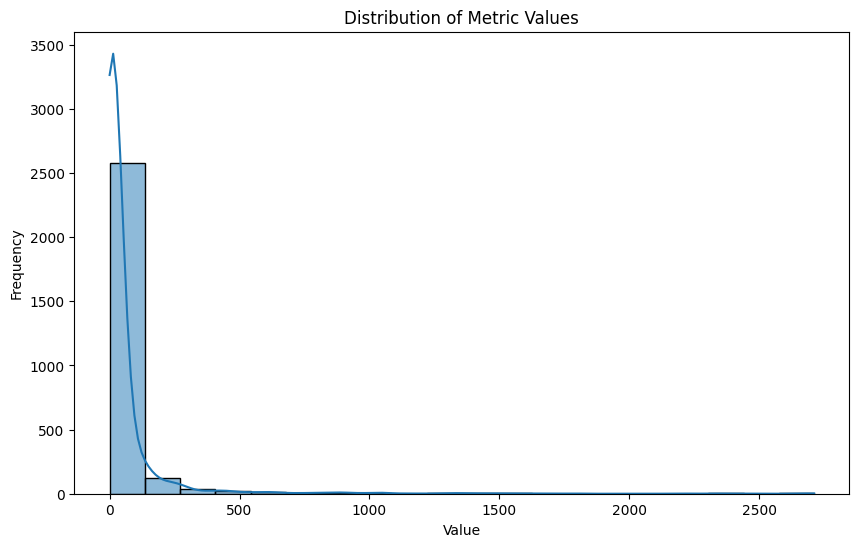

In [18]:
summary_statistics = label_count.describe()

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(label_count['Value'], kde=True, bins=20)
plt.title('Distribution of Metric Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()


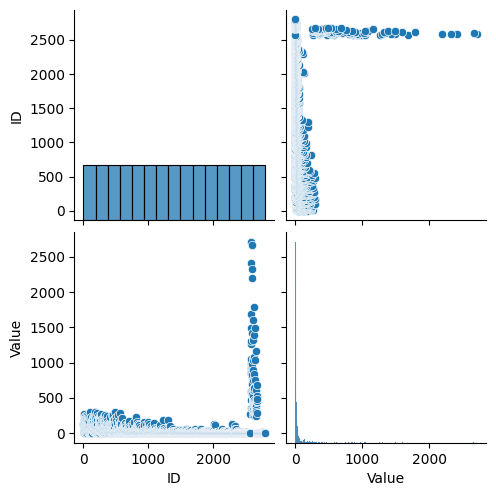

In [23]:
sns.pairplot(label_count)
plt.show()

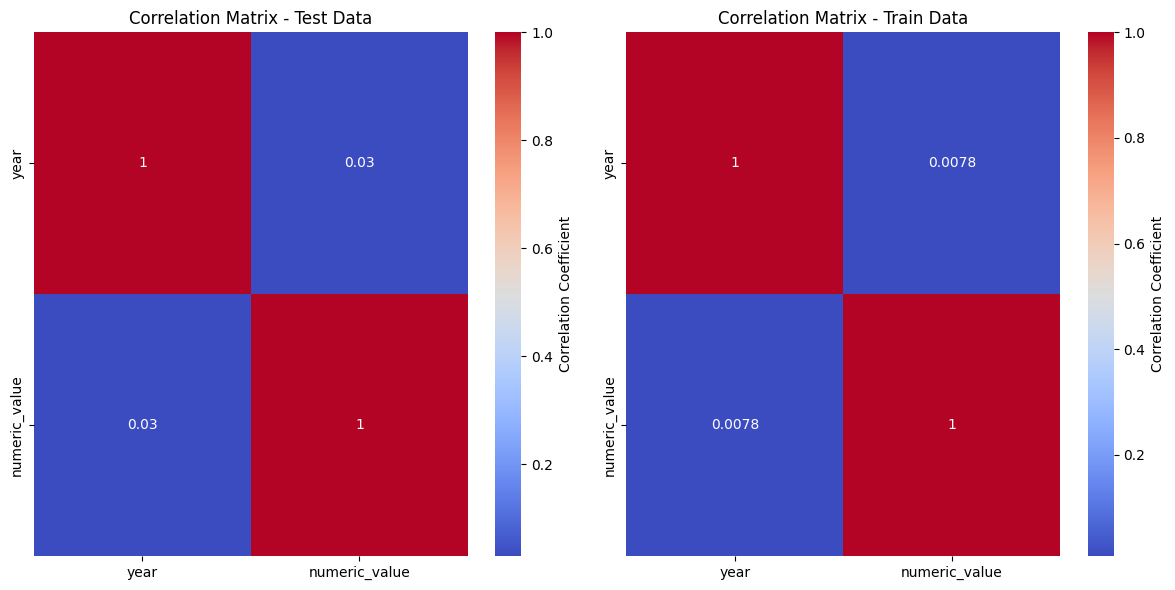

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast  # For converting string representations of dictionaries/lists

# Function to extract numeric values from numerals-tags
def extract_numeric_values(df):
    numeric_values = []
    for index, row in df.iterrows():
        tags = ast.literal_eval(row['numerals-tags'])
        for tag, values in tags.items():
            for value in values:
                try:
                    # Convert value to float, if possible
                    numeric_values.append(float(value.replace(',', '').replace('$', '')))
                except ValueError:
                    continue
    return numeric_values

# Extract numeric values for both datasets
numeric_values_test = extract_numeric_values(test_sample)
numeric_values_train = extract_numeric_values(train_sample)

# Ensure the length of numeric values matches the DataFrame's length for accurate correlation analysis
# Using the year column and numeric values for correlation
correlation_data_test = pd.DataFrame({
    'year': test_sample['year'],
    'numeric_value': numeric_values_test[:len(test_sample)]  # Slicing to match the length
})

correlation_data_train = pd.DataFrame({
    'year': train_sample['year'],
    'numeric_value': numeric_values_train[:len(train_sample)]  # Slicing to match the length
})

# Calculate the correlation matrices
correlation_test = correlation_data_test.corr()
correlation_train = correlation_data_train.corr()

# Plotting the correlation matrices using seaborn
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.heatmap(correlation_test, annot=True, cmap='coolwarm', cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Matrix - Test Data')

plt.subplot(1, 2, 2)
sns.heatmap(correlation_train, annot=True, cmap='coolwarm', cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Matrix - Train Data')

plt.tight_layout()
plt.show()


Year vs. Numeric Value: The correlation coefficient is
0.029
0.029, indicating a very weak positive correlation between the document year and the numerical values reported. This suggests that the year has minimal influence on the magnitude of the numbers reported in the documents.

Year vs. Numeric Value: The correlation coefficient is approximately
0.008
0.008, similarly indicating an almost negligible positive correlation.

The heatmap visualizations of these correlation matrices confirm that there's no strong relationship between the year of the document and the numeric values it contains, which might be expected as financial figures can vary widely irrespective of the year.

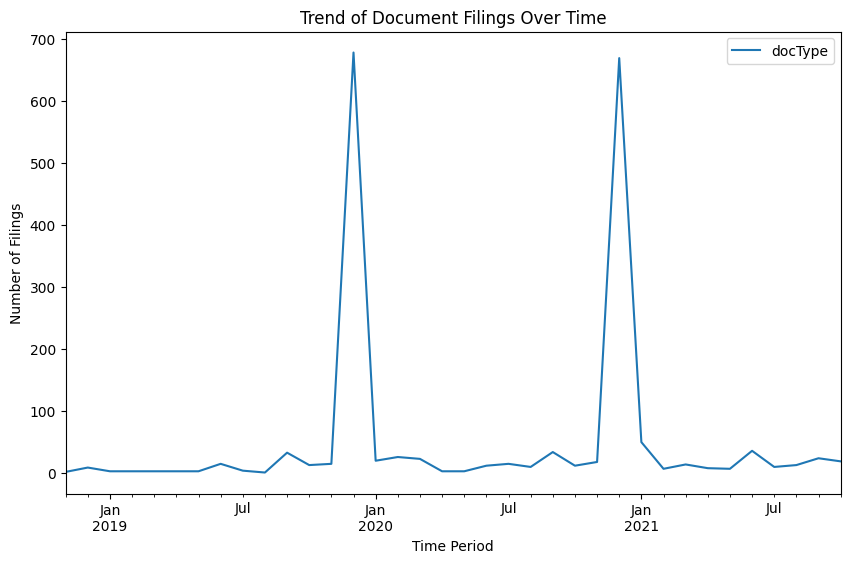

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert 'docEndDate' to datetime and handle missing data
datasets = [test_sample, train_sample, labelCount]
for dataset in datasets:
    if 'docEndDate' in dataset.columns:
        dataset['docEndDate'] = pd.to_datetime(dataset['docEndDate'], errors='coerce')

# Create a combined dataset focusing on 'docEndDate' and 'docType'
trend_analysis_data = pd.DataFrame()
for dataset in datasets:
    if 'docEndDate' in dataset.columns:
        dataset['Time Period'] = dataset['docEndDate'].dt.to_period("M")  # Monthly period
        if 'docType' in dataset.columns:
            trend_analysis_data = pd.concat([trend_analysis_data, dataset[['Time Period', 'docType']]])

# Drop rows with missing 'Time Period' or 'docType'
trend_analysis_data.dropna(subset=['Time Period', 'docType'], inplace=True)

# Count filings by time period
filings_by_time = trend_analysis_data.groupby('Time Period').count()

# Plotting the trend of document filings over time
filings_by_time.plot(kind='line', figsize=(10, 6))
plt.title('Trend of Document Filings Over Time')
plt.xlabel('Time Period')
plt.ylabel('Number of Filings')
plt.show()


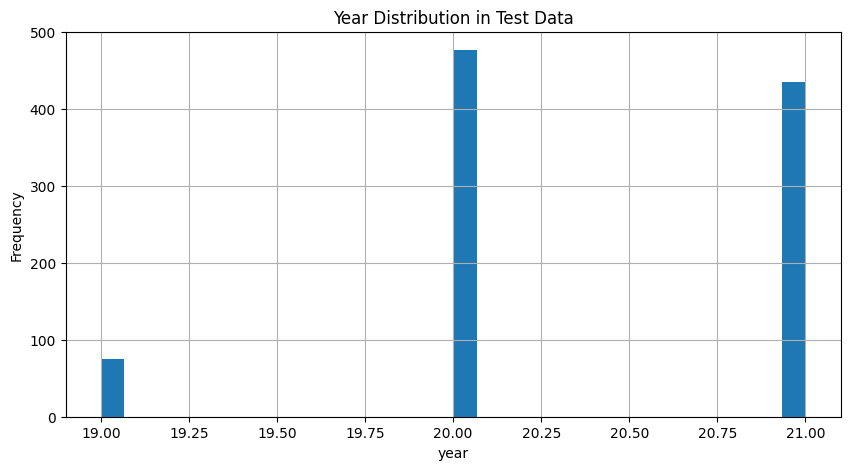

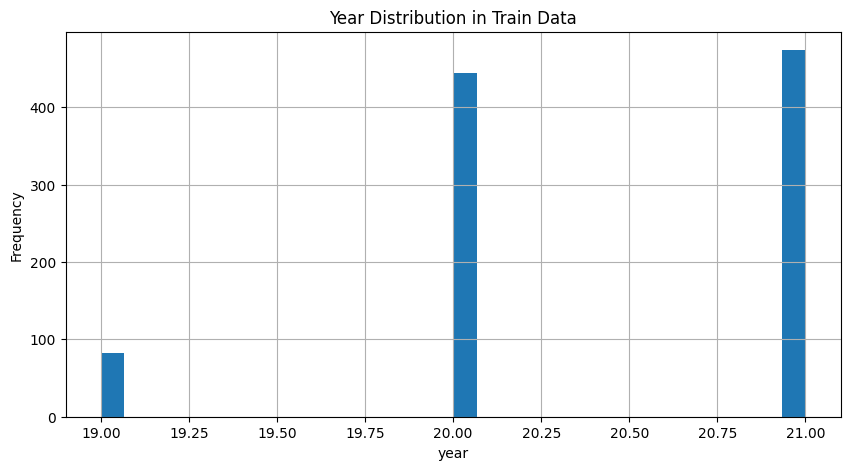

In [29]:
import matplotlib.pyplot as plt

def plot_numerical_distribution(df, column, title):
    plt.figure(figsize=(10, 5))
    df[column].hist(bins=30)  # You can adjust the number of bins based on your preference
    plt.title(title)
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

# Plotting the year distribution for test and train datasets
plot_numerical_distribution(test_sample, 'year', 'Year Distribution in Test Data')
plot_numerical_distribution(train_sample, 'year', 'Year Distribution in Train Data')


In [31]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import ast  # Used for converting string representations of lists/dictionaries into actual lists/dictionaries

# Function to analyze numerals-tags by extracting them and counting the most common
def analyze_numerals_tags(df):
    all_tags = [ast.literal_eval(tags) for tags in df['numerals-tags']]
    tag_counts = Counter([tag for sublist in all_tags for tag in sublist])
    return tag_counts.most_common(10)

# Getting the most common numerals-tags for further analysis
common_numerals_tags_test = analyze_numerals_tags(test_sample)[:5]  # Top 5 tags from test data
common_numerals_tags_train = analyze_numerals_tags(train_sample)[:5]  # Top 5 tags from train data

# Function to gather context around numerals-tags, displaying sentences containing these tags
def gather_context(df, num_tags):
    context_data = []
    for index, row in df.iterrows():
        tags = ast.literal_eval(row['numerals-tags'])
        for tag in tags:
            if tag in num_tags:
                context_data.append((tag, row['sentence']))
    return context_data

# Select top common numerals-tags from test and train datasets for deeper analysis
top_tags_test = [tag[0] for tag in common_numerals_tags_test]
top_tags_train = [tag[0] for tag in common_numerals_tags_train]

# Gather contexts for these top tags in both datasets
context_examples_test = gather_context(test_sample, top_tags_test)
context_examples_train = gather_context(train_sample, top_tags_train)

# Display some examples of context around the tags
print("Context Examples from Test Data:")
for tag, sentence in context_examples_test[:5]:
    print(f"Tag: {tag}\nSentence: {sentence}\n")

print("Context Examples from Train Data:")
for tag, sentence in context_examples_train[:5]:
    print(f"Tag: {tag}\nSentence: {sentence}\n")


Context Examples from Test Data:
Tag: us-gaap:BusinessCombinationContingentConsiderationLiability
Sentence: The $10.9 million fair value of the contingent consideration element as of the acquisition date was estimated by applying the income approach based on a discounted cash flow technique using Monte Carlo simulations.

Tag: us-gaap:StockRepurchasedAndRetiredDuringPeriodValue
Sentence: In fiscal year 2017, we repurchased and retired 2.2 million shares of our common stock for $73.9 million.

Tag: us-gaap:IndefiniteLivedIntangibleAssetsExcludingGoodwill
Sentence: The Company has trademarks that total $248 million that are indefinite lived and we test annually for impairment on the first day of the fourth quarter.

Tag: us-gaap:ProceedsFromLinesOfCredit
Sentence: From January1, 2020 through February 21, 2020, the Company borrowed an additional $55.0 million under its revolving credit facility, resulting in $55.0 million of outstanding borrowings under the revolving credit facility as of

Numerals-tags are tags associated with numeric data in the text, providing context and meaning to the numbers, which is critical for financial analysis. The function analyze_numerals_tags parses these tags from the datasets and counts their occurrences. This step is crucial for identifying which tags are most commonly used, indicating their importance or frequency of use in financial documents. This could be particularly useful for tasks such as automated tagging or document summarization systems focused on financial content.

The gather_context function is designed to extract the textual context in which these numerals-tags appear. By understanding the sentences that contain these tags, one can gain insights into how financial figures are discussed or disclosed in real-world documents. This step helps in building models that need to understand or generate similar contexts or in creating systems that help in auditing or reviewing financial documents.